In [2]:
#%%
import sys
root = '/home/mitch/PythonProjects/learn_sciml/tdsf-pinn'
# root = '/home/mitch/PythonProjects/tdsf-pinn'
sys.path.append(f'{root}/src')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from data.load_tdsf_data import load_tdsf_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def make_X_Y_cnsts(df, dt, ds, trunc, cnsts):

    # define shape of PINN I/O
    tv = np.arange(1,trunc+1)*dt
    tv = tv[::ds]

    # stack w,h, and t vectors to make inputs, X
    df['X'] = df.apply(lambda x: np.concatenate((x.YIELD*np.ones((tv.size,1)), 
                                                 x.DEPTH*np.ones((tv.size,1)), 
                                                 np.reshape(tv,(-1,1))), axis=1).astype(np.float32), 
                       axis=1)
    
    # truncate and decimate tdsf vectors to make targets, Y
    df['Y'] = df.DATA.map(lambda x: np.reshape(x[:trunc][::ds], (-1,1)).astype(np.float32))

    # 
    df['cnsts'] = df.apply(lambda x: (x[cnsts].values*np.ones((tv.size,1))).astype(np.float32),
                      axis=1)
    return df

# Define all hyperparams and run params here
algo = 'PINN'
experiment = 'agu2'

# Data params
vers = '002.1'
materials = ['Tuff-Rhyolite']
df = load_tdsf_data(vers, root)
df = df[df['material'].isin(materials)]
df = df.reset_index(drop=True)



trunc = 1000
ds = 10
dt = 0.001

# velocity model constants associated with the tdsf
cnsts = ['$h_o$', '$R_o$', '$y_0$', '$P_{1o}$', '$P_{2o}$', '$n$', 'C', '$V_S$', '$\\rho$']

# process inputs (wht) and targets (tdsf)
df = make_X_Y_cnsts(df, dt, ds, trunc, cnsts).iloc[9]
print(f'Yield: {df.YIELD} Depth: {df.DEPTH}')

Yield: 1.32 Depth: 160.0


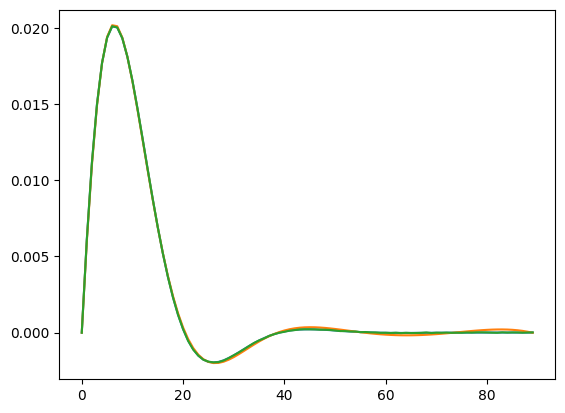

Loss: 3.377e-06 da-1.060e-08 bo-2.497e-10 sw-9.334027e-07 sh-2.432732e-06


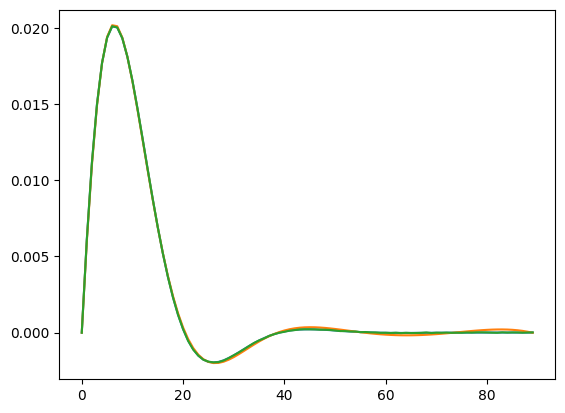

In [9]:


class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, act, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = act
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss



def exact_solution(w,h,t,con):
    ''' 
    derived analytical expressions for ds/dw and ds/dh
    w: (b, 1, 1) - yields of the point source
    h: (b, 1, 1) - vertical source-to-receiver distance
    t: (b, 1, nt) - time points
    
    '''
    batch_size, _, nt = t.shape

    ho,Ro,go,P1,P2,n,pv,sv,rho = con

    Rel = Ro*((ho/h)**(1/n))*(w**(1/3))
    ga = go*Ro/Rel
    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu    
    wo = pv/Rel
    bet = (lam+2*mu)/(4*mu)
    alp = wo/(2*bet)
    p = wo*(1/2/bet-1/4/bet**2)**(1/2)

    def dF_(t):
        return (Rel*pv**2)/(4*mu*bet*p)*(-alp*torch.exp(-alp*t)*torch.sin(p*t) + p*torch.exp(-alp*t)*torch.cos(p*t))

    def dBdR_(t):
        t1 = t*ga*torch.exp(-ga*t)/Rel*P1*(h/ho)
        t2 = (t*ga*torch.exp(-ga*(t))+3*(1-torch.exp(-ga*(t))))/Rel*P2*((ho/h)**(1/3))*((Ro/Rel)**3)*(w**(0.87))
        return t1-t2
    
    dF = dF_(t)
    dBdR = dBdR_(t)
    
    # convolve
    dsdR = torch.nn.functional.conv1d(dF.view(1, batch_size, dF.size(-1)), 
                                    torch.flip(dBdR,dims=[-1]).view(batch_size, -1, dBdR.size(-1)), 
                                    padding='same', bias=None, groups=batch_size).view(batch_size, -1, nt)

    dRdw = 1/3*Ro*((ho/h)**(1/n))*(w**(-2/3))
    dRdh = -1/n*((ho/h)**(1/n))*(1/h)*(w**(1/3))
    dsdw = dsdR*dRdw
    dsdh = dsdR*dRdh
    
    return dF, dBdR, dsdR, dRdw, dRdh, dsdw, dsdh

## PDE as loss function. Thus would use the network which we call as u_theta
def f_partial(data, net, con, y):
    '''
    data: (b, nt, 3) unnormalized (..., [w,h,t]) vectors
    '''

    wvec = Variable(data[:,:,0], requires_grad=True) # (b, nt)
    hvec = Variable(data[:,:,1], requires_grad=True) # (b, nt)
    tvec = Variable(data[:,:,2], requires_grad=True) # (b, nt)

    x = (wvec*hvec*tvec).reshape(-1, tvec.shape[-1], 1)

    s = net((x - x.mean())/(x.std()))

    
    # remove normalization
    s = s*(y.max() - y.min()) + y.min()
    
    s_w = torch.autograd.grad(s.sum(), wvec, create_graph=True)[0]
    s_h = torch.autograd.grad(s.sum(), hvec, create_graph=True)[0]

    
    dF, dBdR, dsdR, dRdw, dRdh, dsdw, dsdh = exact_solution(wvec.mean(axis=-1).reshape(-1,1,1),
                                                            hvec.mean(axis=-1).reshape(-1,1,1),
                                                            tvec.reshape(data.shape[0],1,-1),
                                                            con)
    
    
    return s, s_w, dsdw, s_h, dsdh

def train(model, scheduler, x, y, n_iter, optimizer, lam_d, lam_sw, lam_sh, scale, con):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ln1, = ax.plot(y.squeeze(), label='True')
    ln2, = ax.plot(y.squeeze(), label='Pred')
    ln3, = ax.plot(y.squeeze(), label='Noisy')
    

    model.train()

    data, target = Variable(x, requires_grad=True).to(device), Variable(y, requires_grad=True).to(device)
    
    
    for i in range(n_iter):
        noise = scale*torch.randn_like(target)
        
        optimizer.zero_grad()
        
        output, s_w, dsdw, s_h, dsdh = f_partial(data, model, con, target)
        
        
        #data loss
        mse_d = criterion(output,target+noise) 
        loss_d = lam_d*mse_d

        # boundary loss
        t0 = torch.tensor(0.).to(device)
        tl = torch.tensor(0.).to(device)
        loss_b = criterion(output[:,0,:], t0) +  criterion(output[:,-1,:], tl)
        
        # phyiscs loss
        mse_sw = criterion(s_w.flatten().squeeze(), dsdw.flatten().squeeze())
        mse_sh = criterion(s_h.flatten().squeeze(), dsdh.flatten().squeeze())
        
        loss_sw = lam_sw*mse_sw
        loss_sh = lam_sh*mse_sh

        loss = loss_d + loss_b + loss_sw + loss_sh
               

        loss.backward()
        optimizer.step()
        scheduler.step(loss)


        if i % 1 == 0:
            print(f'Iteration: {i} Loss: {loss.item():.3e} da-{loss_d:.3e} bo-{loss_b:.3e} sw-{loss_sw:.6e} sh-{loss_sh:.6e} lr: {scheduler._last_lr[0]:.3e}', end='\r')
            ln1.set_ydata(y.squeeze())
            ln2.set_ydata(output.squeeze().detach().cpu().numpy())
            ln3.set_ydata(y.squeeze()+noise.detach().cpu().squeeze())
            display.clear_output(wait=True)
            display.display(pl.gcf())
            
            
            
            # time.sleep(1.0)
            # plt.show()
    
    return loss.mean().item(), loss_d.mean().item(), loss_b.mean().item(), loss_sw.mean().item(), loss_sh.mean().item(), s_w.mean().item(), dsdw.mean().item(), s_h.mean().item(), dsdh.mean().item()
    

# Training params
lr = 1.E-3
ntz = 100
cut = 10
nt = ntz-cut
# NN params
input_size = nt
output_size = input_size

# Save results path
results_path = f'{root}'



# Model and training params
lam_d = 1. # data loss penalty

lam_sh = 1.e-9 # Physics loss penalty for mse_sh
lam_sw = 1.e-18 # Physics loss penalty for mse_sw
scale = 0.00001 # noise scale

n_iter = 1000

# shuffle and sample by time points
X, Y = np.vstack(df.X)[cut:ntz], np.vstack(df.Y)[cut:ntz]

numIn = 1
numOut = Y.shape[-1]


X = torch.from_numpy(X.reshape(-1, nt, 3))
Y = torch.from_numpy(Y.reshape(-1, nt, 1))

con = [122., # ho
       202., # Ro
       26., # go
       3.6*1e6, # P1
       5.0*1e6, # P2
       2.4, # n
       3500, # pv
       2021, # sv
       2000 # rho
        ]



# loss, loss_d, loss_b, loss_sw, loss_sh, s_w, dsdw, s_h, dsdh = out
# phy_loss_tr = loss_sw + loss_sh

In [ ]:
# Training loop
modelname = f'PINN_FCNN_bondary_test'
model_path = f'{results_path}/{modelname}.pt'



# Setup model and optimizer.
model = NeuralNet(input_dimension=1, 
                  output_dimension=1, 
                  n_hidden_layers=6, 
                  neurons=96,
                  act = torch.nn.GELU('tanh'), 
                #   act = torch.nn.Tanh(), 
                  regularization_param=0.5, 
                  regularization_exp=2,
                  retrain_seed=128).to(device)

# Select Optimizer and Loss Criterion
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', .75, 100, cooldown=25)
out = train(model, scheduler, X,Y, n_iter, optimizer, lam_d, lam_sw, lam_sh, scale, con)

#%% Save Data and Model
torch.save(model, f'{results_path}/{modelname}.pt')